In [1]:
import config
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import utils

In [3]:
imagePath = os.path.join(config.cwd, "data", "images", "cl8k2u1pm1dw7083203g1b7yv.jpg")
rawImage = cv2.imread(imagePath)

In [42]:
impaintedImage = utils.preprocess_image(rawImage)

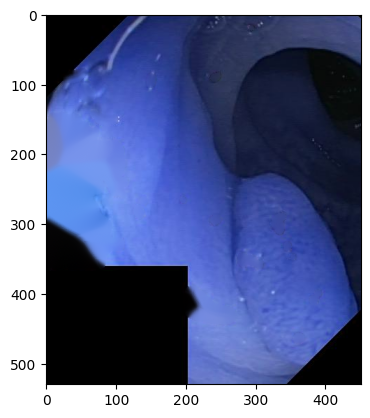

In [43]:
plt.imshow(impaintedImage)

First, it is necessary to convert the image from the original
RGB channel to grey scale to process the subsequent procedure

In [4]:
grayScale = cv2.cvtColor(rawImage, cv2.COLOR_BGR2GRAY)

the proposed approach employs standard thresholding method with a fixed threshold
value to identify specular highlights in all images

In [5]:
threshold = 180
_, thresholded = cv2.threshold(grayScale, threshold, 255, cv2.THRESH_BINARY)

 More specifically, a dilation operation with kernel size 3 × 3
is performed initially to connect the pixels related to undesirable parts.

In [6]:
dilated = cv2.dilate(thresholded, kernel=np.ones((3, 3), np.uint8), iterations=1)

Among the obtained
contours, those whose scaled area following the Modified Z-scores formula [30], as shown in
Formula 1, exceeds 17.0 

In [7]:
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(dilated)
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 17: #This may be wrongly calculated
        cv2.drawContours(mask, [contour], -1, 255, -1)

The mask is then passed into another
erosion module with the same settings to restore the initial highlights intensity

In [8]:
eroded = cv2.erode(mask, kernel=np.ones((3, 3), np.uint8), iterations=1)

 Finally, Gaussian
filter of size 19 × 19 is applied to reduce the intensity of highlights area and improve the
inpainting performance.


In [32]:
smoothed = cv2.GaussianBlur(eroded, (19, 19), 0)
_, binary_mask = cv2.threshold(smoothed, 20, 1, cv2.THRESH_BINARY)

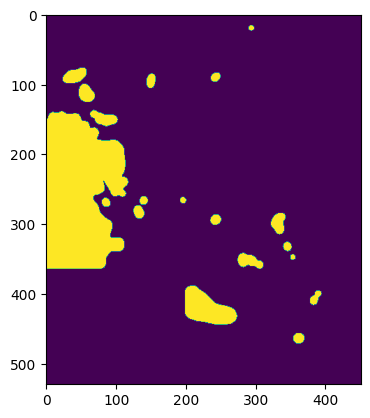

In [33]:
plt.imshow(binary_mask)

First, a filter of size 3×3 slides across every pixels of the original image and calculate the average
value

In [34]:
blurred_image = cv2.blur(rawImage, (3, 3))

In [35]:
replacedPixels = cv2.bitwise_and(blurred_image,blurred_image,mask = smoothed)
blacked = np.zeros_like(rawImage)

In [36]:
result = np.where(binary_mask[:, :, np.newaxis] == 1, replacedPixels, rawImage)

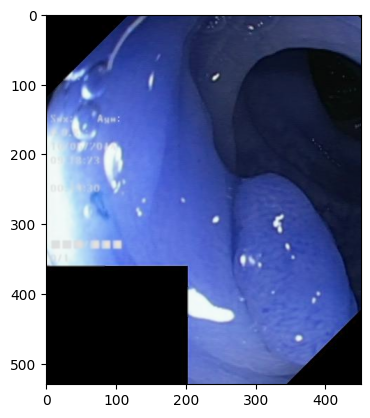

In [37]:
plt.imshow(result)

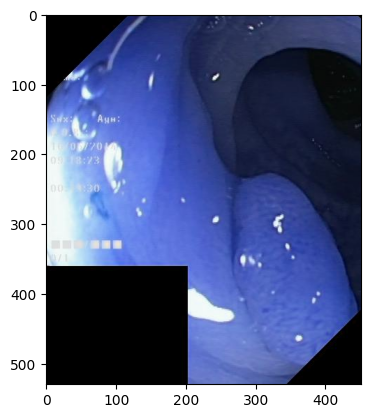

In [17]:
plt.imshow(rawImage)

In [38]:
inpainted = cv2.inpaint(result, binary_mask, 5, cv2.INPAINT_TELEA)

NameError: name 'result' is not defined

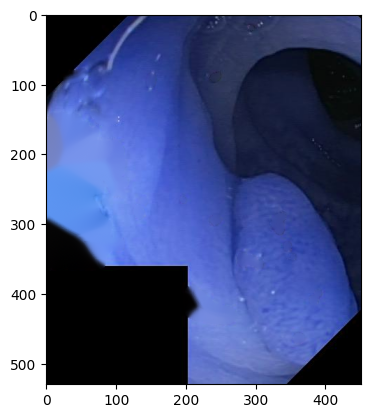

In [39]:
plt.imshow(inpainted)

<h1>Black Mask removal</h1>

In [1]:
import config
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import utils

In [2]:
imagePath = os.path.join(config.cwd, "data", "images", "cl8k2u1pm1dw7083203g1b7yv.jpg")
secondImagePath = os.path.join(config.cwd, "data", "images", "clb0lbwzidp7c086u77jyb2a7.jpg")
thirdImagePath = os.path.join(config.cwd, "data", "images", "clb0lbwzidp7w086u9bpq7y7v.jpg")
rawImage = cv2.imread(imagePath)
secondRawImage = cv2.imread(secondImagePath)
thirdRawImage = cv2.imread(thirdImagePath)

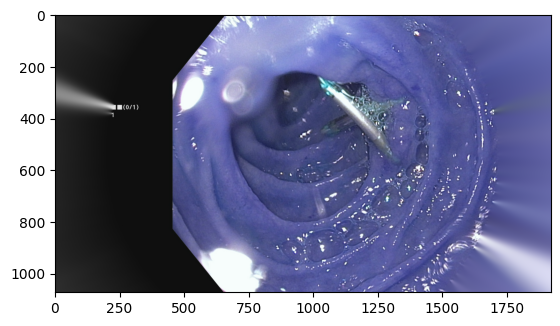

In [4]:
plt.imshow(utils.removeBlackBackground(secondRawImage))

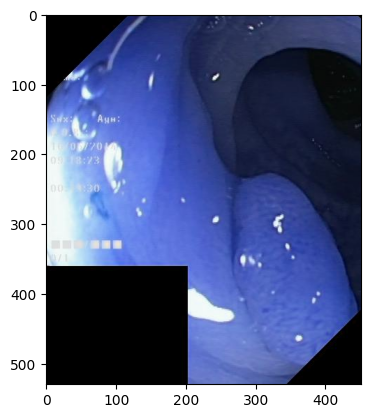

In [3]:
plt.imshow(rawImage)

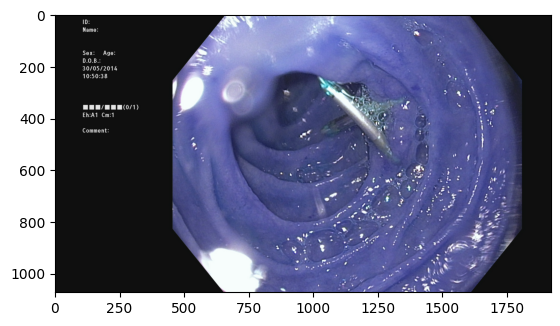

In [4]:
plt.imshow(secondRawImage)

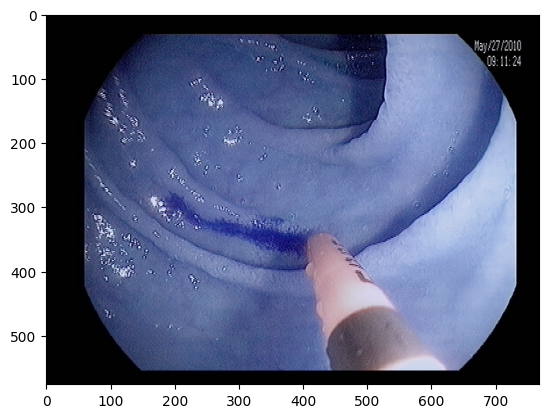

In [5]:
plt.imshow(thirdRawImage)

In [6]:
gray = cv2.cvtColor(thirdRawImage, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY_INV)

In [7]:
kernel = np.ones((3, 3), np.uint8)
eroded = cv2.erode(thresholded, kernel, iterations=2)

In [8]:
distance_transform = cv2.distanceTransform(eroded, cv2.DIST_L2, 3)
distance_transform = cv2.erode(distance_transform, kernel, iterations=3)

In [9]:
upDistance = 0
foundBorder = False
for i in range(distance_transform.shape[0]):
    for j in range(distance_transform.shape[1]):
        if distance_transform[i,j] == 0:
            foundBorder = True
    if foundBorder:
        break;
    upDistance += 1
print(upDistance)

26


In [10]:
downDistance = 0
foundBorder = False
for i in range(distance_transform.shape[0] - 1, -1, -1):
    for j in range(distance_transform.shape[1]):
        if distance_transform[i,j] == 0:
            foundBorder = True
    if foundBorder:
        break;
    downDistance += 1
print(downDistance)

12


In [11]:
leftDistance = 0
foundBorder = False
for j in range(distance_transform.shape[1]):
    for i in range(distance_transform.shape[0]):
        if distance_transform[i,j] == 0:
            foundBorder = True
    if foundBorder:
        break;
    leftDistance += 1
print(leftDistance)

52


In [12]:
rightDistance = 0
foundBorder = False
for j in range(distance_transform.shape[1] - 1, -1, -1):
    for i in range(distance_transform.shape[0]):
        if distance_transform[i,j] == 0:
            foundBorder = True
    if foundBorder:
        break;
    rightDistance += 1
print(rightDistance)

22


In [13]:
centerX = int(((distance_transform.shape[1] - rightDistance - leftDistance) / 2) + leftDistance)
centerY = int(((distance_transform.shape[0] - upDistance - downDistance) / 2) + upDistance)
print(centerX, centerY)

399 295


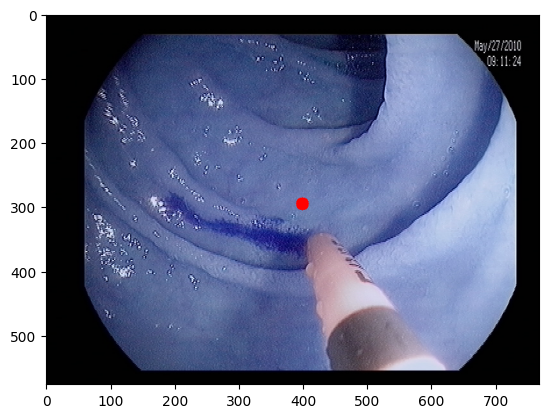

In [32]:
center = (centerX, centerY)  # (x, y) coordinates

# Define the color of the point (e.g., white for grayscale images, or a tuple like (255, 0, 0) for RGB blue)
color = (255, 0, 0)  # Blue color for RGB image, or 255 for white in grayscale

# Define the radius of the point (small value to make it a "dot")
radius = 10  # Adjust as needed

# Define the thickness (usually -1 fills the circle, making it a solid dot)
thickness = -1  # -1 means filled

# Draw the point on the image
cv2.circle(thirdRawImage, center, radius, color, thickness)
plt.imshow(thirdRawImage)

In [33]:
thresch = 10

In [34]:
#left upper detection
distance_left_upper = 0
mostPosibleSteps = min(centerX, centerY)
currentX = centerX
currentY = centerY
for _ in range(mostPosibleSteps):
    currentX -= 1
    currentY -= 1
    if distance_transform[currentX, currentY] < thresch:
        distance_left_upper += np.sqrt(2)
    else:
        break
distance_left_upper = int(np.floor(distance_left_upper))
print(distance_left_upper)

350


In [35]:
#right upper detection
distance_right_upper = 0
mostPosibleSteps = min(distance_transform.shape[0] - centerX, centerY)
currentX = centerX
currentY = centerY
for _ in range(mostPosibleSteps):
    currentX += 1
    currentY -= 1
    if distance_transform[currentX, currentY] < thresch:
        distance_right_upper += np.sqrt(2)
    else:
        break
distance_right_upper = int(np.floor(distance_right_upper))
print(distance_right_upper)

233


In [36]:
#lowwer upper detection
distance_right_lower = 0
mostPosibleSteps = min(distance_transform.shape[0] - centerX, distance_transform.shape[1] - centerY)
currentX = centerX
currentY = centerY
for _ in range(mostPosibleSteps):
    currentX += 1
    currentY += 1
    if distance_transform[currentX, currentY] < thresch:
        distance_right_lower += np.sqrt(2)
    else:
        break
distance_right_lower = int(np.floor(distance_right_lower))
print(distance_right_lower)

240


In [77]:
maskRadius = int(np.floor((distance_left_upper + distance_right_upper + distance_right_lower) / 3))
bigMaskRadius = max(distance_left_upper, distance_right_upper, distance_right_lower)
print(maskRadius)

274


In [69]:
upperLeftX = leftDistance
upperLeftY = upDistance
lowerRightY = distance_transform.shape[0] - rightDistance
lowerRightX =  distance_transform.shape[1] - downDistance
print(lowerRightX)
print(lowerRightY)

756
554


In [70]:
mask_height, mask_width = eroded.shape[:2]
mask = np.zeros((mask_height, mask_width), dtype=np.uint8)

rect_mask = cv2.rectangle(mask, (upperLeftX, upperLeftY), (lowerRightX, lowerRightY), 255, -1)
rect_mask = cv2.bitwise_not(rect_mask)

circle_mask = cv2.circle(np.zeros((mask_height, mask_width), dtype=np.uint8), (centerX, centerY), maskRadius, 255, -1)
circle_mask = cv2.bitwise_not(circle_mask)

combined_mask = cv2.bitwise_or(rect_mask, circle_mask)

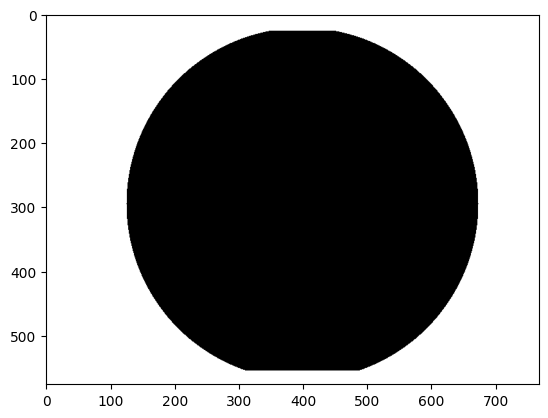

In [71]:
plt.imshow(combined_mask, cmap="grey")

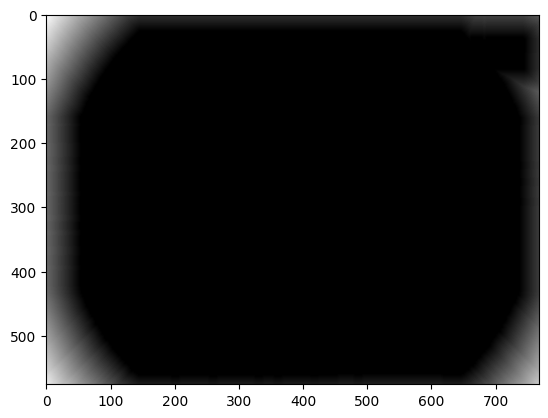

In [72]:
plt.imshow(distance_transform, cmap="grey")

In [73]:
inpainted = cv2.inpaint(thirdRawImage, combined_mask, 5, cv2.INPAINT_TELEA)

In [74]:
inpainted = cv2.inpaint(inpainted, combined_mask, 5, cv2.INPAINT_TELEA)

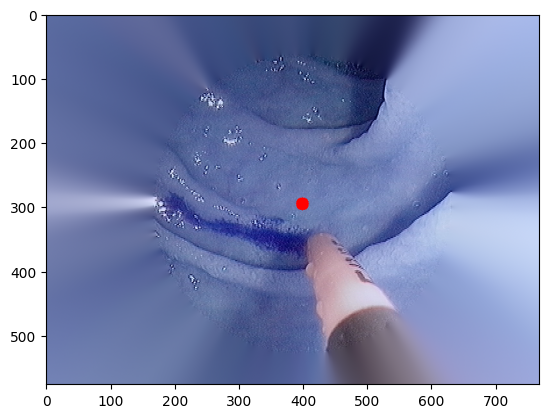

In [63]:
plt.imshow(inpainted)

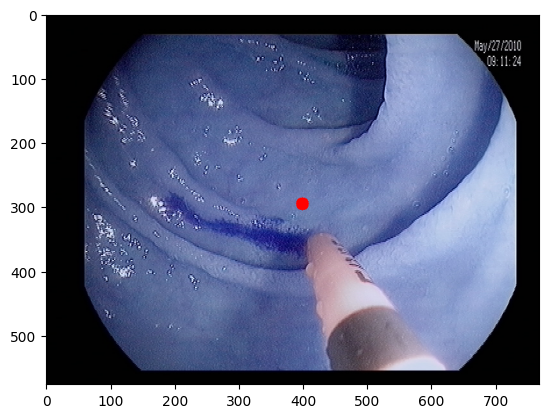

In [75]:
plt.imshow(thirdRawImage)